In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_air_quality = pd.read_csv("data/air_quality_data.csv")
print("Air Quality data is successfully loaded into a dataframe")
print("Air Quality data loaded:", df_air_quality.shape)

# Print the first 5 rows of the air quality dataframe
print("Air Quality Data (first 5 rows):")
print(df_air_quality.head())

Air Quality data is successfully loaded into a dataframe
Air Quality data loaded: (109585, 3)
Air Quality Data (first 5 rows):
   city_name        date  pm2_5
0  Amsterdam  2013-01-01   14.0
1  Amsterdam  2013-01-02    8.0
2  Amsterdam  2013-01-03   12.0
3  Amsterdam  2013-01-04   12.0
4  Amsterdam  2013-01-05   14.0


In [6]:
# Deduplication
df_air_quality = df_air_quality.drop_duplicates(subset=["city_name", "date"])

# Check for missing critical fields
missing_aq = df_air_quality[["city_name", "date"]].isna().sum()

print("Missing values in Air Quality dataset:\n", missing_aq)

Missing values in Air Quality dataset:
 city_name    0
date         0
dtype: int64


In [8]:
# Fill missing dates per city
def complete_city_dates(df):
    all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max())
    cities = df['city_name'].unique()
    df_full = []
    
    for city in cities:
        city_df = df[df['city_name'] == city].set_index('date').reindex(all_dates).reset_index()
        city_df.rename(columns={'index':'date'}, inplace=True)
        city_df['city_name'] = city
        df_full.append(city_df)
    
    return pd.concat(df_full, ignore_index=True)

In [10]:
# Ensure date column is in datetime format
df_air_quality['date'] = pd.to_datetime(df_air_quality['date'])

# Fill missing dates for each city
old_shape = df_air_quality.shape[0]

df_air_quality = complete_city_dates(df_air_quality)

print("Missing dates filled per city successfully!")
print("Original rows:", old_shape)
print("New rows:", df_air_quality.shape[0])
print("Rows added:", df_air_quality.shape[0] - old_shape)

Missing dates filled per city successfully!
Original rows: 109585
New rows: 112590
Rows added: 3005


In [11]:
missing_aq = df_air_quality[["city_name", "date"]].isna().sum()

print("Missing values in Air Quality dataset:\n", missing_aq)

Missing values in Air Quality dataset:
 city_name    0
date         0
dtype: int64


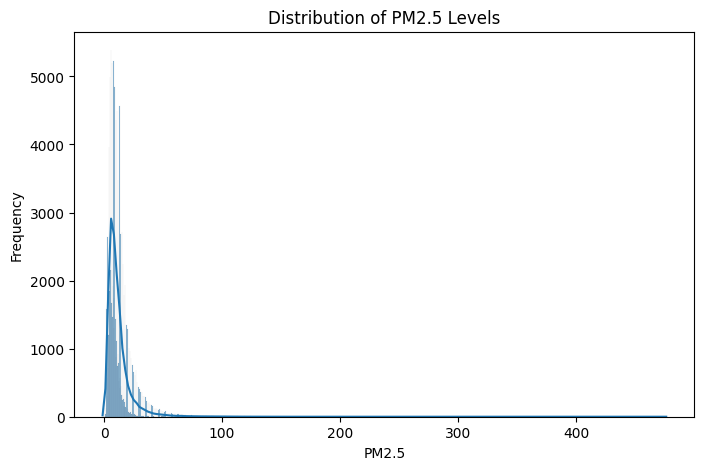

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df_air_quality['pm2_5'], kde=True)
plt.title("Distribution of PM2.5 Levels")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.show()


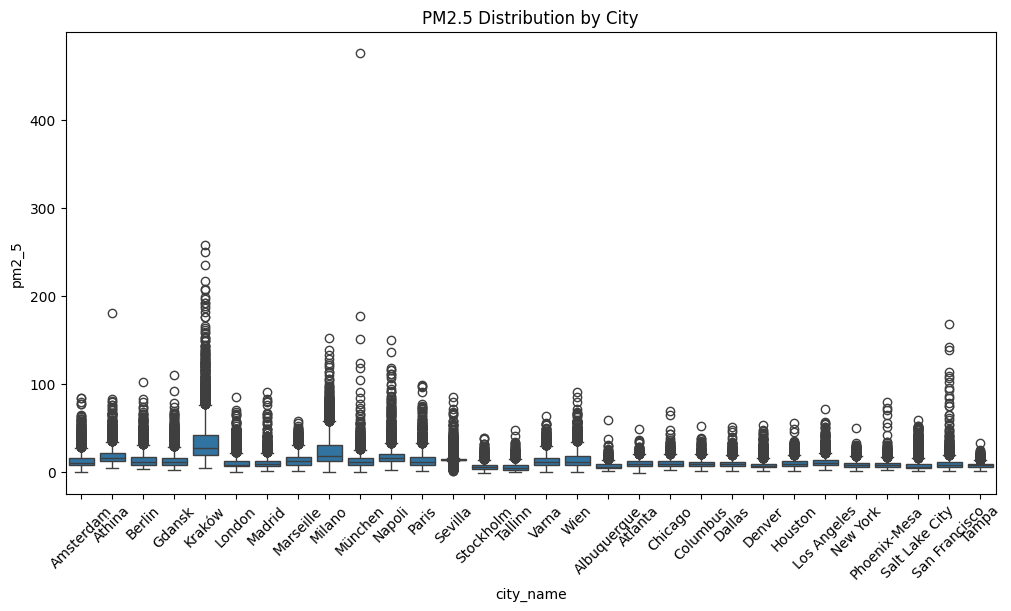

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_air_quality, x='city_name', y='pm2_5')
plt.xticks(rotation=45)
plt.title("PM2.5 Distribution by City")
plt.show()


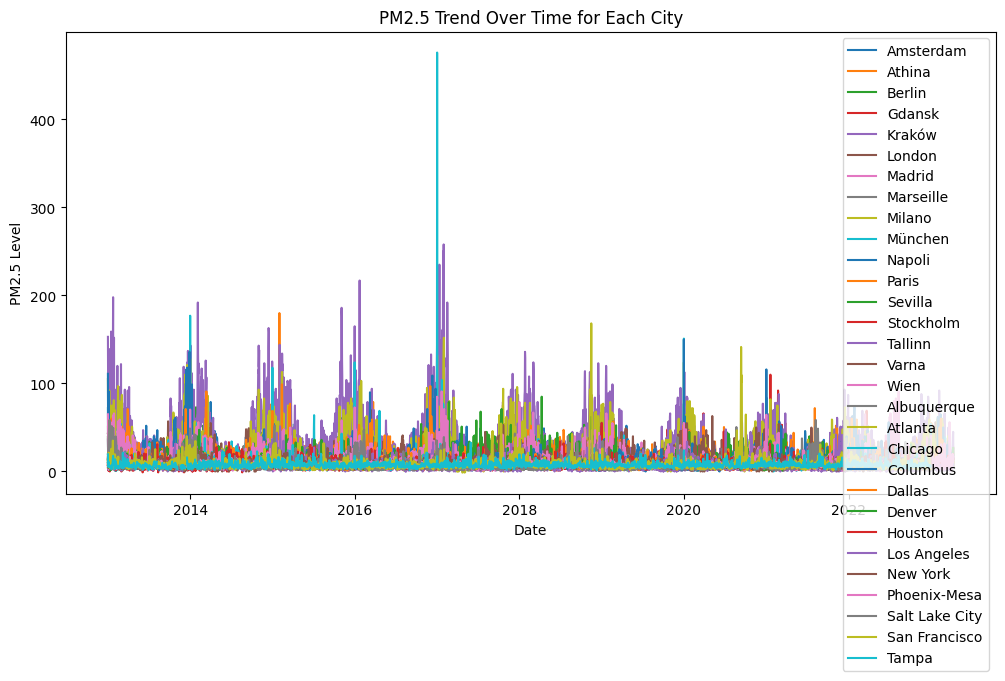

In [15]:
plt.figure(figsize=(12,6))
for city in df_air_quality['city_name'].unique():
    city_df = df_air_quality[df_air_quality['city_name'] == city]
    plt.plot(city_df['date'], city_df['pm2_5'], label=city)

plt.title("PM2.5 Trend Over Time for Each City")
plt.xlabel("Date")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.show()


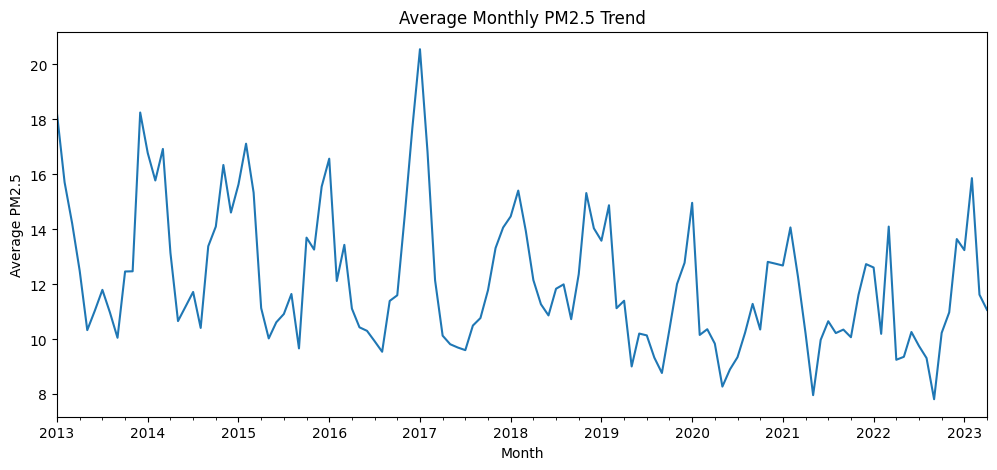

In [16]:
df_air_quality['month'] = df_air_quality['date'].dt.to_period('M')
monthly_mean = df_air_quality.groupby('month')['pm2_5'].mean()

plt.figure(figsize=(12,5))
monthly_mean.plot()
plt.title("Average Monthly PM2.5 Trend")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.show()


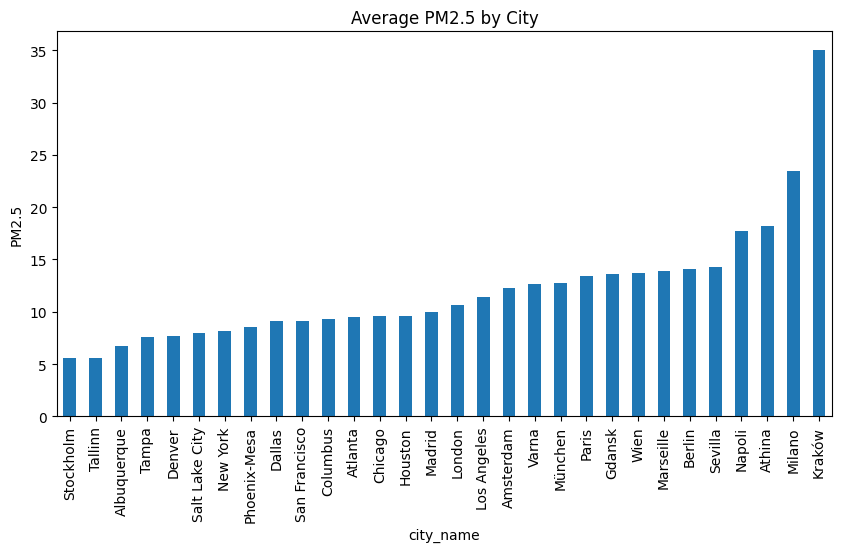

In [17]:
city_mean = df_air_quality.groupby('city_name')['pm2_5'].mean().sort_values()

plt.figure(figsize=(10,5))
city_mean.plot(kind='bar')
plt.title("Average PM2.5 by City")
plt.ylabel("PM2.5")
plt.show()


In [28]:
# Ensure PM2.5 is non-negative
df_air_quality['pm2_5'] = df_air_quality['pm2_5'].clip(lower=0)

# Impute missing values
df_air_quality['pm2_5'].interpolate(method='linear', inplace=True)
df_air_quality['pm2_5'].fillna(df_air_quality['pm2_5'].mean(), inplace=True)

# Apply log transformation safely
df_air_quality['log_pm2_5'] = np.log1p(df_air_quality['pm2_5'])

# Check for any -inf or NaN
print("Any NaNs in log_pm2_5?", df_air_quality['log_pm2_5'].isna().sum())
print("Any -inf values in log_pm2_5?", np.isinf(df_air_quality['log_pm2_5']).sum())

Any NaNs in log_pm2_5? 0
Any -inf values in log_pm2_5? 0


In [26]:
# Log Transformation
df_air_quality['log_pm2_5'] = np.log1p(df_air_quality['pm2_5'])
print("Log transformation applied to PM2.5.")

Log transformation applied to PM2.5.


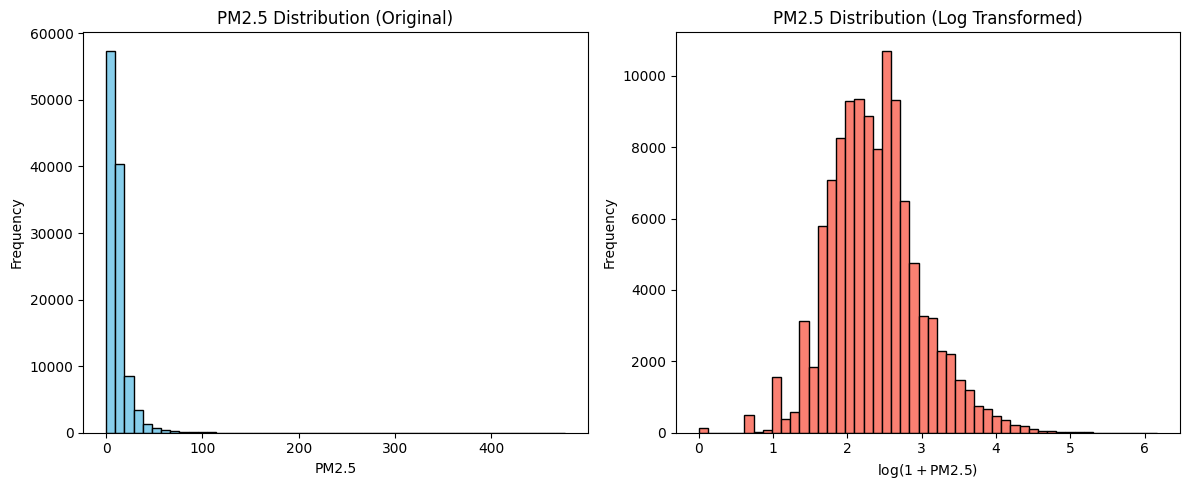

In [29]:
# Histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df_air_quality['pm2_5'], bins=50, color='skyblue', edgecolor='black')
plt.title("PM2.5 Distribution (Original)")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(df_air_quality['log_pm2_5'], bins=50, color='salmon', edgecolor='black')
plt.title("PM2.5 Distribution (Log Transformed)")
plt.xlabel(r"$\log(1 + \text{PM2.5})$")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


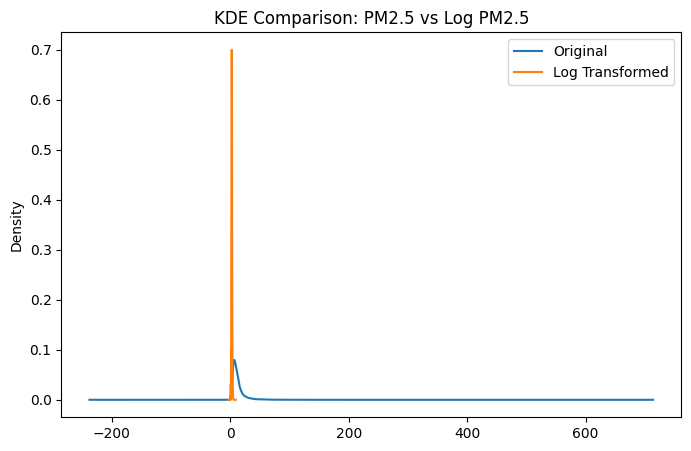

In [30]:
#  Smooth Distribution Comparison
plt.figure(figsize=(8,5))
df_air_quality['pm2_5'].plot(kind='kde', label="Original")
df_air_quality[log_pm25_col].plot(kind='kde', label="Log Transformed")
plt.title("KDE Comparison: PM2.5 vs Log PM2.5")
plt.legend()
plt.show()

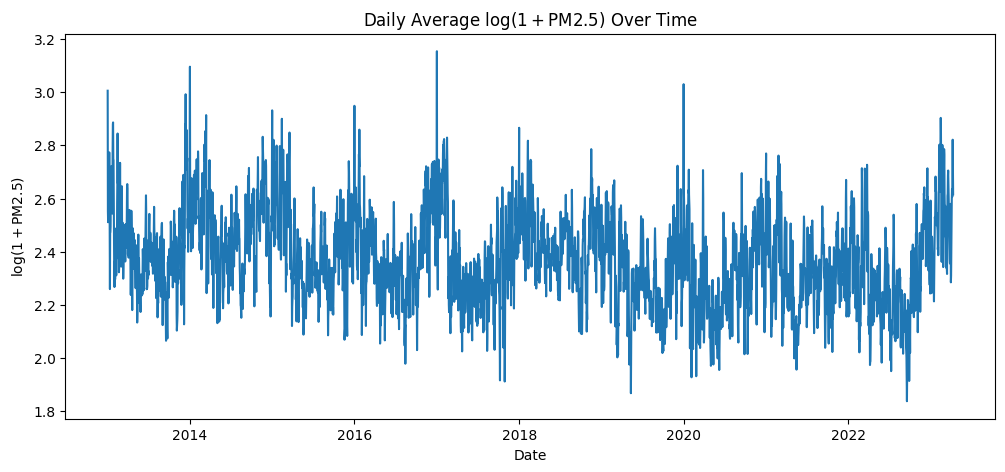

In [31]:
# Time Trend Plot — Log Values Over Time
df_air_quality_group = df_air_quality.groupby('date')[log_pm25_col].mean()

plt.figure(figsize=(12,5))
plt.plot(df_air_quality_group.index, df_air_quality_group.values)
plt.title(r"Daily Average $\log(1 + \text{PM2.5})$ Over Time")
plt.xlabel("Date")
plt.ylabel(r"$\log(1 + \text{PM2.5})$")
plt.show()

In [32]:
import os

# Define the output file path and name
output_file_name = "data/final_air_quality_data.csv"

# Save the DataFrame 
df_air_quality.to_csv(output_file_name, index=False)

# Confirmation message
print(f"DataFrame successfully saved to: {os.path.abspath(output_file_name)}")
print(f"The saved DataFrame has {df_air_quality.shape[0]} rows and {df_air_quality.shape[1]} columns.")

DataFrame successfully saved to: D:\Air-Quality\data\final_air_quality_data.csv
The saved DataFrame has 112590 rows and 5 columns.
